In [5]:
import pandas as pd
import numpy as np
from IPython.display import display
from IPython.display import FileLink
import os
import seaborn as sns
import matplotlib.pyplot as plt
import gc

# Only exploring 2018 case data

### Loading the final processed file

In [5]:
# do for all years
cleanProcData=pd.read_csv('/kaggle/input/cleanedcriminalcasedata2018-proc/cleanedCriminalCaseData2018.csv',index_col='ddl_case_id',dtype={'ddl_case_id':'str','date_of_filing':'str','date_of_decision':'str'})
print(cleanProcData.shape)

(6757967, 5)


In [6]:
# dropping all rows where either criminal is NaN
cleanProcData=cleanProcData.dropna(subset=['criminal'])
print(cleanProcData.shape)

(6757967, 5)


In [7]:
cleanProcData.drop('bailable_ipc',axis=1,inplace=True)
cleanProcData.head()

,date_of_filing,date_of_decision,criminal,duration
ddl_case_id,,,,
01-01-01-201900000012018,2018-01-01,2018-02-07,0,37.0
01-01-01-201900000022018,2018-01-01,2018-02-01,1,31.0
01-01-01-201900000032018,2018-01-01,2018-02-01,1,31.0
01-01-01-201900000042018,2018-01-01,2018-02-01,1,31.0
01-01-01-201900000052018,2018-01-01,2018-01-09,1,8.0


### Calculating the mean time in court for criminal and non-criminal cases

In [8]:
cleanProcData=cleanProcData.astype({'duration':'int'}) # needed to calculate the mean

In [15]:
criminalsSeparated=cleanProcData.groupby('criminal')['duration']
averages=criminalsSeparated.mean()
print('Average court time in days')
averages

Average court time in days


criminal
0    94.359612
1    64.277696
Name: duration, dtype: float64

### Removing outliers

In [13]:
# just printing the percentiles out ,to get an idea of the data
percentile25=criminalsSeparated.quantile(0.25)
percentile75=criminalsSeparated.quantile(0.75)
iqr=percentile75-percentile25
print('interquartile range',iqr)


criminal
0    138.0
1     66.0
Name: duration, dtype: float64


In [17]:
# calculating mean without outlier data
noncriminals=criminalsSeparated.get_group(0)
print('Before removing outliers:',noncriminals.shape)
noncriminalsProc=noncriminals[(noncriminals>(percentile25.loc[0]-1.5*iqr.loc[0])) & (noncriminals<(percentile75.loc[0]+2*iqr.loc[0]))]
print('after removing outliers',noncriminalsProc.shape)
adjustedAverages=pd.Series({0:noncriminalsProc.mean()})

criminals=criminalsSeparated.get_group(1)
print('Before removing outliers:',criminals.shape)
criminalsProc=criminals[(criminals>(percentile25.loc[1]-1.5*iqr.loc[1])) & (criminals<(percentile75.loc[1]+2.5*iqr.loc[1]))]
print('after removing outliers:',criminalsProc.shape)
adjustedAverages=adjustedAverages.append(pd.Series({1:criminalsProc.mean()}))

print('Average court time after removing outliers in days')
adjustedAverages

Before removing outliers: (3969516,)
after removing outliers (3774724,)
Before removing outliers: (2788451,)
after removing outliers: (2497670,)
Average court time after removing outliers in days


0    71.225706
1    30.865148
dtype: float64

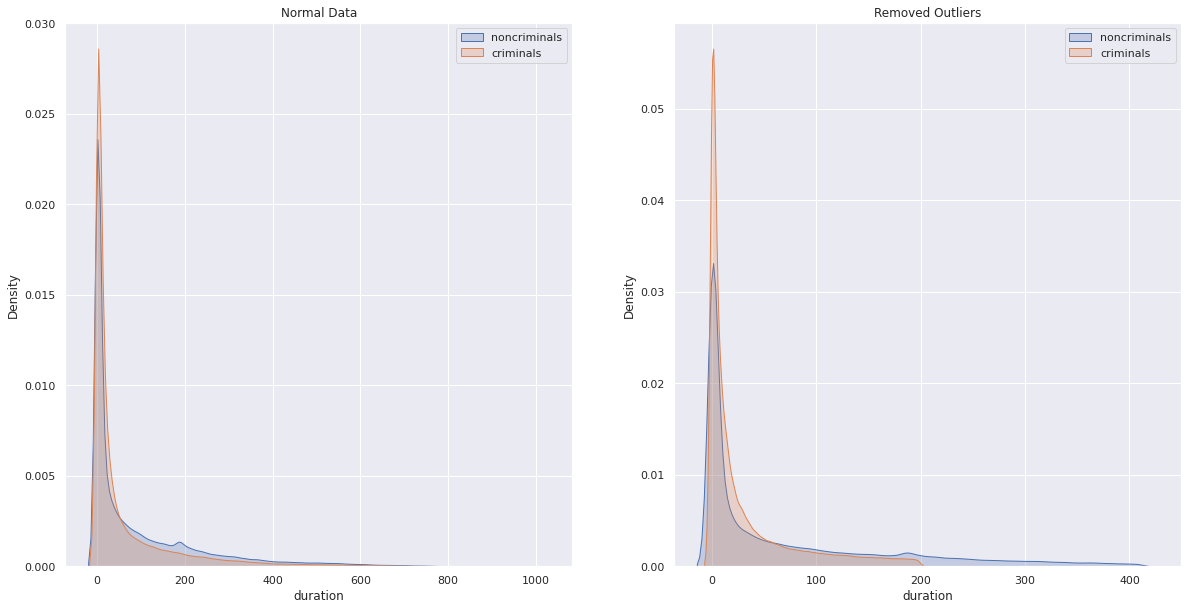

In [18]:
sns.set()
fig,axs=plt.subplots(1,2,figsize=(20,10))
axs[0].set_title('Normal Data')
axs[1].set_title('Removed Outliers')

sns.kdeplot(noncriminals,ax=axs[0],label='noncriminals',shade=True)
sns.kdeplot(criminals,ax=axs[0],label='criminals',shade=True)
sns.kdeplot(noncriminalsProc,ax=axs[1],label='noncriminals',shade=True)
sns.kdeplot(criminalsProc,ax=axs[1],label='criminals',shade=True)
axs[0].legend()
axs[1].legend()

# we can see from the plot that there are a few cases with very long durations, thus increasing the average

# Run this if you want average over all the years

In [6]:
all_averages_list=[]
# not removing outliers
for i in range(0,9):
    cleanProcData=pd.read_csv('/kaggle/input/cleanedcriminalcasedata/cleanedCriminalCaseData/cleanedCriminalCaseData201%d.csv'%i,index_col='ddl_case_id',dtype={'ddl_case_id':'str','date_of_filing':'str','date_of_decision':'str'})
    # dropping all rows where either criminal is NaN
    cleanProcData=cleanProcData.dropna(subset=['criminal'])
    cleanProcData.drop('bailable_ipc',axis=1,inplace=True)
    cleanProcData=cleanProcData.astype({'duration':'int'}) # needed to calculate the mean
    criminalsSeparated=cleanProcData.groupby('criminal')['duration']
    averages=criminalsSeparated.mean()
    sums=criminalsSeparated.sum()
    count=criminalsSeparated.count()
    all_averages_list.append(['201%d'%i,'no',averages.loc[0],sums.loc[0],count.loc[0]])
    all_averages_list.append(['201%d'%i,'yes',averages.loc[1],sums.loc[1],count.loc[1]])
    del cleanProcData
    del criminalsSeparated
    gc.collect()
    print('201%d processed'%i)



2010 processed
2011 processed
2012 processed
2013 processed
2014 processed
2015 processed
2016 processed
2017 processed
2018 processed


/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


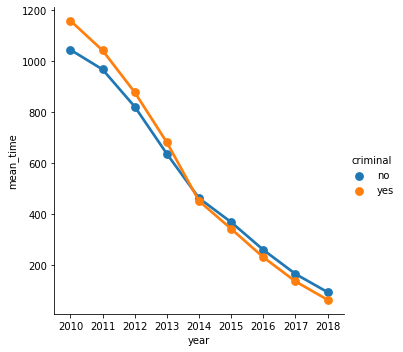

In [8]:
all_averages=pd.DataFrame(data=all_averages_list,columns=['year','criminal','mean_time','total_duration','total_cases'])
all_averages=all_averages.astype(dtype={'year':'str','criminal':'str','mean_time':'float','total_duration':'int','total_cases':'int'})
sns.factorplot(data=all_averages,x='year',y='mean_time',hue='criminal')

In [9]:
bTotal_duration=all_averages.groupby('criminal')['total_duration'].sum()
bTotal_cases=all_averages.groupby('criminal')['total_cases'].sum()
bAverage=bTotal_duration/bTotal_cases
print('Average duration of a case')
bAverage

criminal
no     391.452394
yes    376.837410
dtype: float64

In [11]:
recent_averages=all_averages[(all_averages['year']=='2016') | (all_averages['year']=='2017') | (all_averages['year']=='2018')]
bRecent_average=recent_averages.groupby('criminal')['total_duration'].sum()/recent_averages.groupby('criminal')['total_cases'].sum()
print('Average duration of a case over the last 3 years')
bRecent_average

Average duration of a case over the last 3 years


criminal
no     179.828190
yes    142.908265
dtype: float64